# PNEUMONIA CLASSIFIER
## BIL 443 TERM PROJECT
### Mert Başar Yıldırım | 211101039

## Imports

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import warnings
warnings.filterwarnings ('ignore')
print ("tensorflow version is:",tf.__version__)

tensorflow version is: 2.18.0


### Checking if the dataset is loaded correctly.

In [2]:
xray_data_dir = "../data/chest_xray"
print(os.listdir(xray_data_dir)) 

['chest_xray', 'test', 'train', 'val']


### Defining file paths

In [3]:
train_folder = os.path.join(xray_data_dir, "train")
test_folder = os.path.join(xray_data_dir, "test")
val_folder = os.path.join(xray_data_dir, "val")

### A function for loading dataset images for each class

In [4]:
def load_images_from_directory(directory, image_size=(256, 256)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)

        if os.path.isdir(class_path):  
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, image_size)  
                    img = np.expand_dims(img, axis=-1)  
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error occurred: {img_path}, Error: {e}")  

    return np.array(images), np.array(labels), class_names

In [5]:
try:
    X_train, y_train, class_names = load_images_from_directory(train_folder)
    X_test, y_test, _ = load_images_from_directory(test_folder)
    X_val, y_val, _ = load_images_from_directory(val_folder)

    print(f"Classes: {class_names}")
    print(f"Train dataset shape: {X_train.shape}, Labels shape: {y_train.shape}")
    print(f"Test dataset shape: {X_test.shape}, Labels shape: {y_test.shape}")
    print(f"Validation dataset shape: {X_val.shape}, Labels shape: {y_val.shape}")
except Exception as e:
    print("Error occured:", e)

Classes: ['NORMAL', 'PNEUMONIA']
Train dataset shape: (5216, 256, 256, 1), Labels shape: (5216,)
Test dataset shape: (624, 256, 256, 1), Labels shape: (624,)
Validation dataset shape: (16, 256, 256, 1), Labels shape: (16,)


In [6]:
def plot_sample_images(X, y, class_names, samples_per_class=10):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2, num_classes * 2))
    fig.tight_layout(pad=3.0)
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(y == i)[0]  # Bu sınıfa ait resimlerin indeksleri
        selected_indices = random.sample(list(class_indices), min(len(class_indices), samples_per_class))  # Rastgele seç
        for j, idx in enumerate(selected_indices):
            axes[i, j].imshow(X[idx].squeeze(), cmap='gray')
            axes[i, j].axis('off')
            if j == 0:  # İlk sütunda sınıf adı göster
                axes[i, j].set_title(class_name, fontsize=12)

    plt.show()

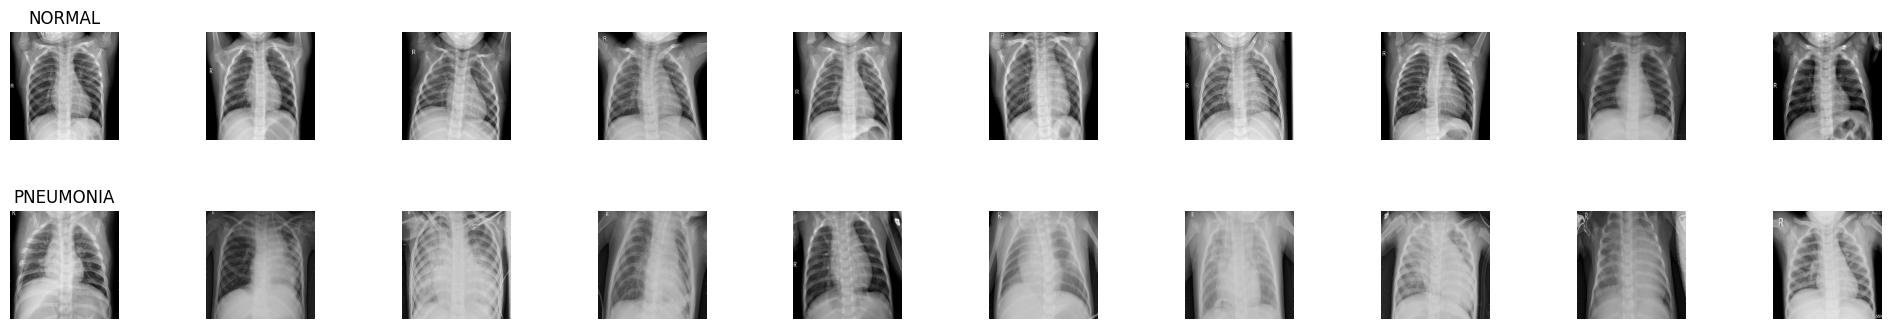

In [7]:
plot_sample_images(X_train, y_train, class_names, samples_per_class=10)

## The Distribution of Dataset

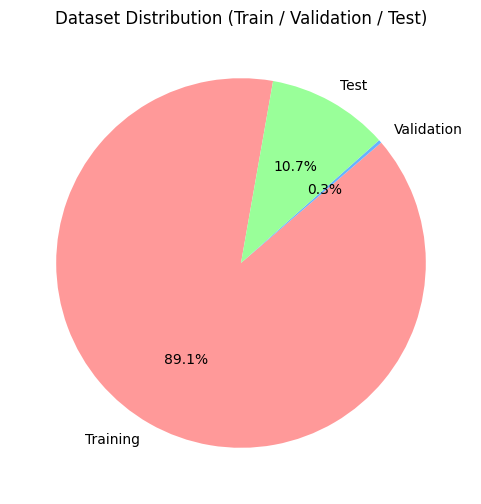

In [8]:
plt.figure(figsize=(6, 6))
plt.pie(x=[len(y_train), len(y_val), len(y_test)], labels=["Training", "Validation", "Test"], autopct='%1.1f%%', startangle=80, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Dataset Distribution (Train / Validation / Test)")
plt.show()

## Distribution of dataset classes

In [9]:
labels = [
    "Training-Normal", "Training-Pneumonia",
    "Validation-Normal", "Validation-Pneumonia",
    "Test-Normal", "Test-Pneumonia"
]
colors = ["red", "red", "blue", "blue", "green", "green"]

train_counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
val_counts = [np.sum(y_val == 0), np.sum(y_val == 1)]
test_counts = [np.sum(y_test == 0), np.sum(y_test == 1)]
class_counts = train_counts + val_counts + test_counts

print("train-normal: "      + str(np.sum(y_train == 0)))
print("train-pneumonia: "   + str(np.sum(y_train == 1)))
print("val-normal: "        + str(np.sum(y_val == 0)))
print("val-pneumonia: "     + str(np.sum(y_val == 1)))
print("test-normal: "       + str(np.sum(y_test == 0)))
print("test-pneumonia: "    + str(np.sum(y_test == 1)))

train-normal: 1341
train-pneumonia: 3875
val-normal: 8
val-pneumonia: 8
test-normal: 234
test-pneumonia: 390


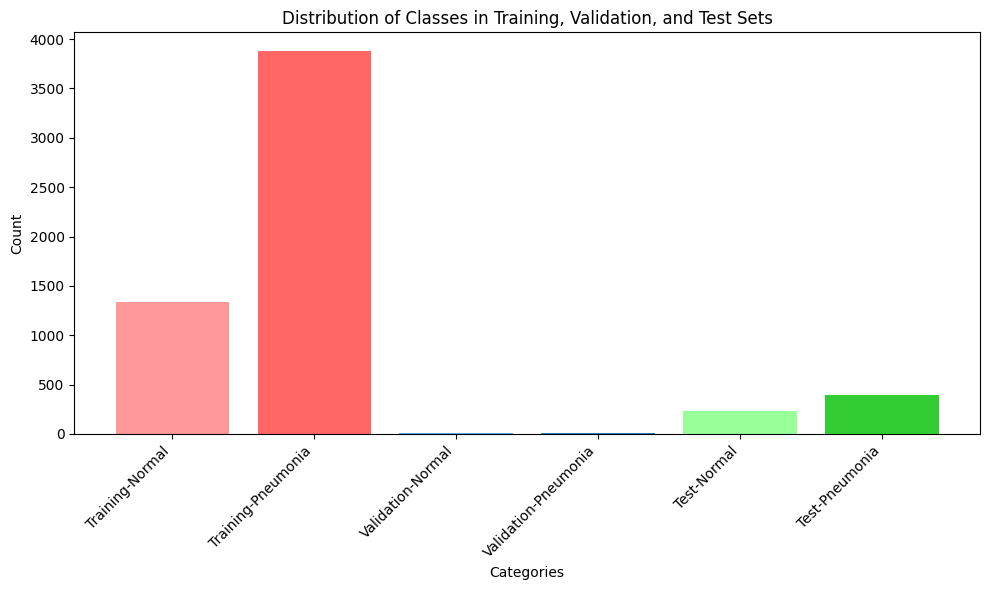

In [10]:
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, height=class_counts, color=['#ff9999', '#ff6666', '#66b3ff', '#3380cc', '#99ff99', '#33cc33'])
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training, Validation, and Test Sets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Data Preprocessing
- Input images are converted to grayscale to enhance feature extraction efficiency.
- All images are resized to a uniform shape of (256, 256, 1) to maintain consistency.
- Pixel values are normalized to the [0,1] range to improve model performance.
- The dataset is initially combined and then stratified into 80% training and 20% validation to ensure balanced representation.
- K-Fold Cross-Validation is implemented with k = 5 to enhance model generalization.
- Class weights are assigned to address class imbalance and improve model learning.

In [11]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [12]:
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

In [13]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [14]:
train_counts_list = []
val_counts_list = []

# Compute class distributions for each fold
for train_idx, val_idx in kf.split(y_combined):
    y_train_fold, y_val_fold = y_combined[train_idx], y_combined[val_idx]

    train_counts_list.append(len(y_train_fold))
    val_counts_list.append(len(y_val_fold))

avg_train_size = np.mean(train_counts_list)
avg_val_size = np.mean(val_counts_list)

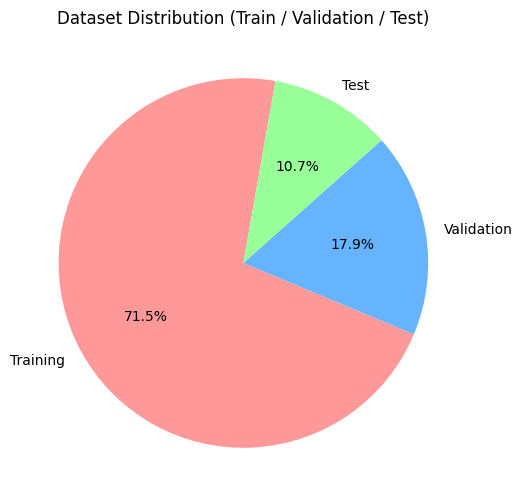

In [15]:
plt.figure(figsize=(6, 6))
plt.pie([avg_train_size, avg_val_size, len(y_test)],
        labels=["Training", "Validation", "Test"],
        autopct='%1.1f%%', startangle=80,
        colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title("Dataset Distribution (Train / Validation / Test)")
plt.show()

In [16]:
train_class_0_list = []
train_class_1_list = []
val_class_0_list = []
val_class_1_list = []

for train_idx, val_idx in kf.split(y_combined):
    y_train_fold, y_val_fold = y_combined[train_idx], y_combined[val_idx]

    # Count classes in train and validation sets
    train_class_0_list.append(np.sum(y_train_fold == 0))
    train_class_1_list.append(np.sum(y_train_fold == 1))
    val_class_0_list.append(np.sum(y_val_fold == 0))
    val_class_1_list.append(np.sum(y_val_fold == 1))

avg_train_class_0 = np.mean(train_class_0_list)
avg_train_class_1 = np.mean(train_class_1_list)
avg_val_class_0 = np.mean(val_class_0_list)
avg_val_class_1 = np.mean(val_class_1_list)
test_class_0 = np.sum(y_test == 0)
test_class_1 = np.sum(y_test == 1)

# Labels and class counts
class_counts = [avg_train_class_0, avg_train_class_1, avg_val_class_0, avg_val_class_1, test_class_0, test_class_1]


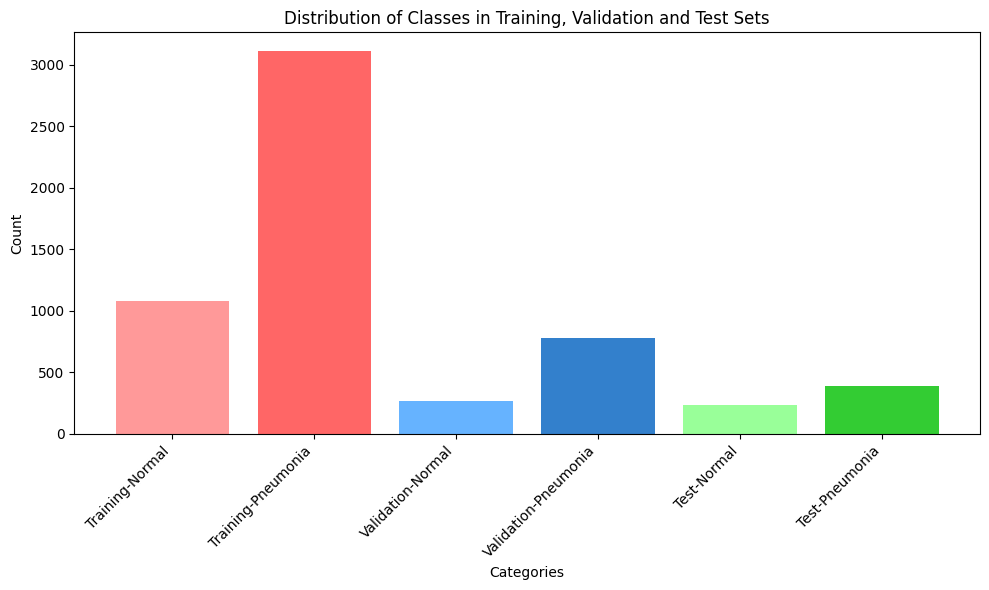

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(labels, height=class_counts, color=['#ff9999', '#ff6666', '#66b3ff', '#3380cc', '#99ff99', '#33cc33'])
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training, Validation and Test Sets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [18]:
class_labels = np.unique(y_combined) 
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=y_combined)
class_weight_dict = dict(zip(class_labels, class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {np.int64(0): np.float64(1.939214232765011), np.int64(1): np.float64(0.6737058975019315)}


# Building the CNN Model

In [19]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1),
                               kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [20]:
example_model = build_model()
example_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,937 (56.61 MB)

 Trainable params: 14,839,233 (56.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [21]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

# K-Fold Training
fold_no = 1
acc_per_fold = []
loss_per_fold = []
histories = []
best_accuracy = 0
best_loss = float('inf')
best_model = None
best_model_history = None

for train_idx, val_idx in kf.split(X_combined):
    print(f"\nTraining Fold {fold_no}/{k}...")

    # Train & Validation Data
    X_train_fold, X_val_fold = X_combined[train_idx], X_combined[val_idx]
    y_train_fold, y_val_fold = y_combined[train_idx], y_combined[val_idx]

    # Create a New Model for Each Fold
    model = build_model()

    # Train Model
    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        epochs=25, batch_size=32,
                        callbacks=[lr_reduction],
                        class_weight=class_weight_dict  
                    )

    histories.append(history)

    # Evaluate Model on Validation Set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_no} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # Best Model Selection Logic
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < best_loss):
        best_accuracy = accuracy
        best_loss = loss
        best_model = model
        best_model_history = history

    loss_per_fold.append(loss)
    acc_per_fold.append(accuracy)

    fold_no += 1


Training Fold 1/5...
Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.8496 - loss: 4.7285 - val_accuracy: 0.7230 - val_loss: 18.1498 - learning_rate: 0.0010
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.9339 - loss: 1.6706 - val_accuracy: 0.7230 - val_loss: 16.4625 - learning_rate: 0.0010
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9377 - loss: 1.4391 - val_accuracy: 0.7278 - val_loss: 2.3037 - learning_rate: 0.0010
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9407 - loss: 1.6581 - val_accuracy: 0.7230 - val_loss: 3.6943 - learning_rate: 0.0010
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.9372 - loss: 1.7039 - val_accuracy: 0.7297 - val_loss: 2.3910 - learning_rate: 0.0010
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9424 - loss: 1.4944 - val_accuracy: 0.8682 - val_loss: 1.8295 - learning_rate: 0.0010
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - acc

## K-fold Average Evaluation

In [22]:
results = []
for fold_idx, history in enumerate(histories):
    train_acc = history.history['accuracy'][-1]  
    train_loss = history.history['loss'][-1]  
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1] 
    
    test_acc = acc_per_fold[fold_idx]
    test_loss = loss_per_fold[fold_idx]

    results.append([fold_idx + 1, train_acc, train_loss, val_acc, val_loss, test_acc, test_loss])

df_results = pd.DataFrame(results, columns=["Fold", "Training Accuracy", "Training Loss", "Validation Accuracy", "Validation Loss", "Test Accuracy", "Test Loss"])

In [23]:
# Print formatted K-Fold results as a table
header = f"{'Fold':<6}{'Training Acc':<15}{'Training Loss':<15}{'Validation Acc':<15}{'Validation Loss':<15}{'Test Acc':<15}{'Test Loss':<15}"
print(header)
print("=" * len(header))

for fold_idx, history in enumerate(histories):
    train_acc = history.history['accuracy'][-1] 
    train_loss = history.history['loss'][-1]  
    val_acc = history.history['val_accuracy'][-1] 
    val_loss = history.history['val_loss'][-1]  
    
    test_acc = acc_per_fold[fold_idx]
    test_loss = loss_per_fold[fold_idx]

    # Print row for this fold
    row = f"{fold_idx+1:<6}{train_acc:<15.4f}{train_loss:<15.4f}{val_acc:<15.4f}{val_loss:<15.4f}{test_acc:<15.4f}{test_loss:<15.4f}"
    print(row)

print("=" * len(header))

Fold  Training Acc   Training Loss  Validation Acc Validation LossTest Acc       Test Loss      
1     0.9668         0.4529         0.9675         0.4275         0.7196         1.3725         
2     0.9737         0.4466         0.9713         0.4698         0.8157         0.9831         
3     0.9806         0.3814         0.8595         0.6083         0.9006         0.5855         
4     0.9701         0.4684         0.9130         0.6541         0.6554         2.0777         
5     0.9792         0.2919         0.9723         0.3122         0.7885         0.8556         


## Best Model Performance Evaluation

In [24]:
# accuracy and loss
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 312ms/step - accuracy: 0.8874 - loss: 0.6466
Test Accuracy: 0.9006410241127014
Loss: 0.5855421423912048


In [25]:
# Classification Report
y_pred = best_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       234
           1       0.91      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



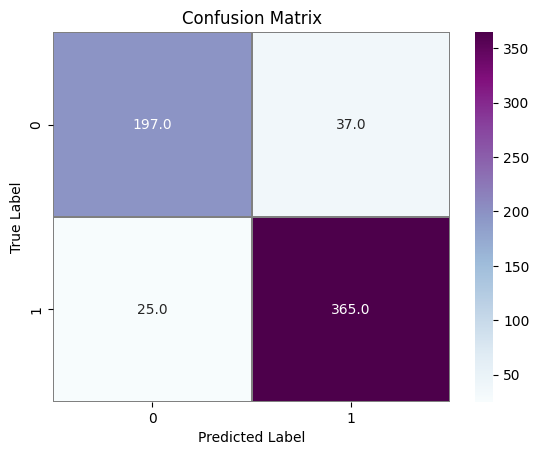

In [26]:
cm = confusion_matrix(y_test, y_pred_classes) 
f,ax = plt.subplots()
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

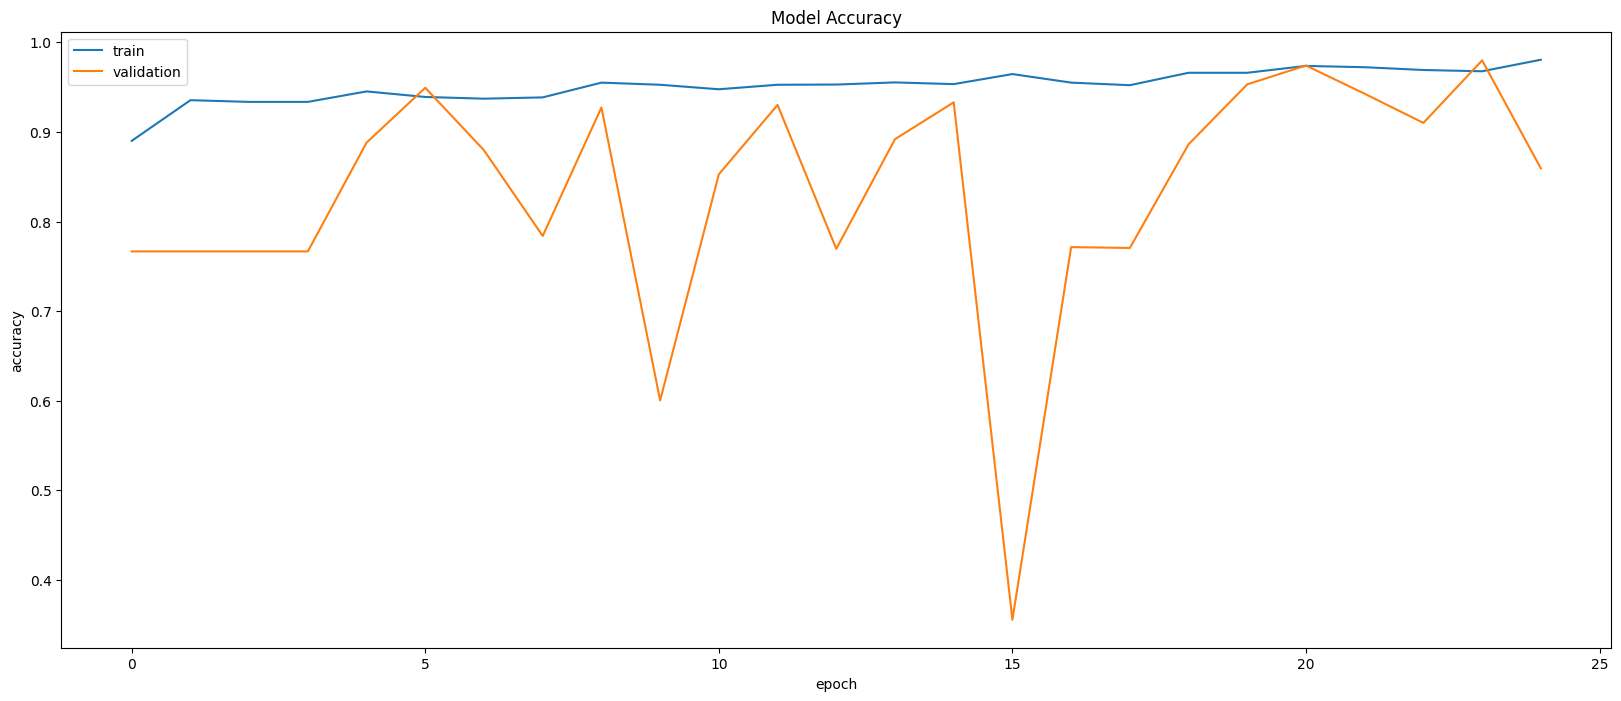

In [27]:
# Plot accuracy
plt.figure(figsize=(20, 8))
plt.plot(best_model_history.history['accuracy'])
plt.plot(best_model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

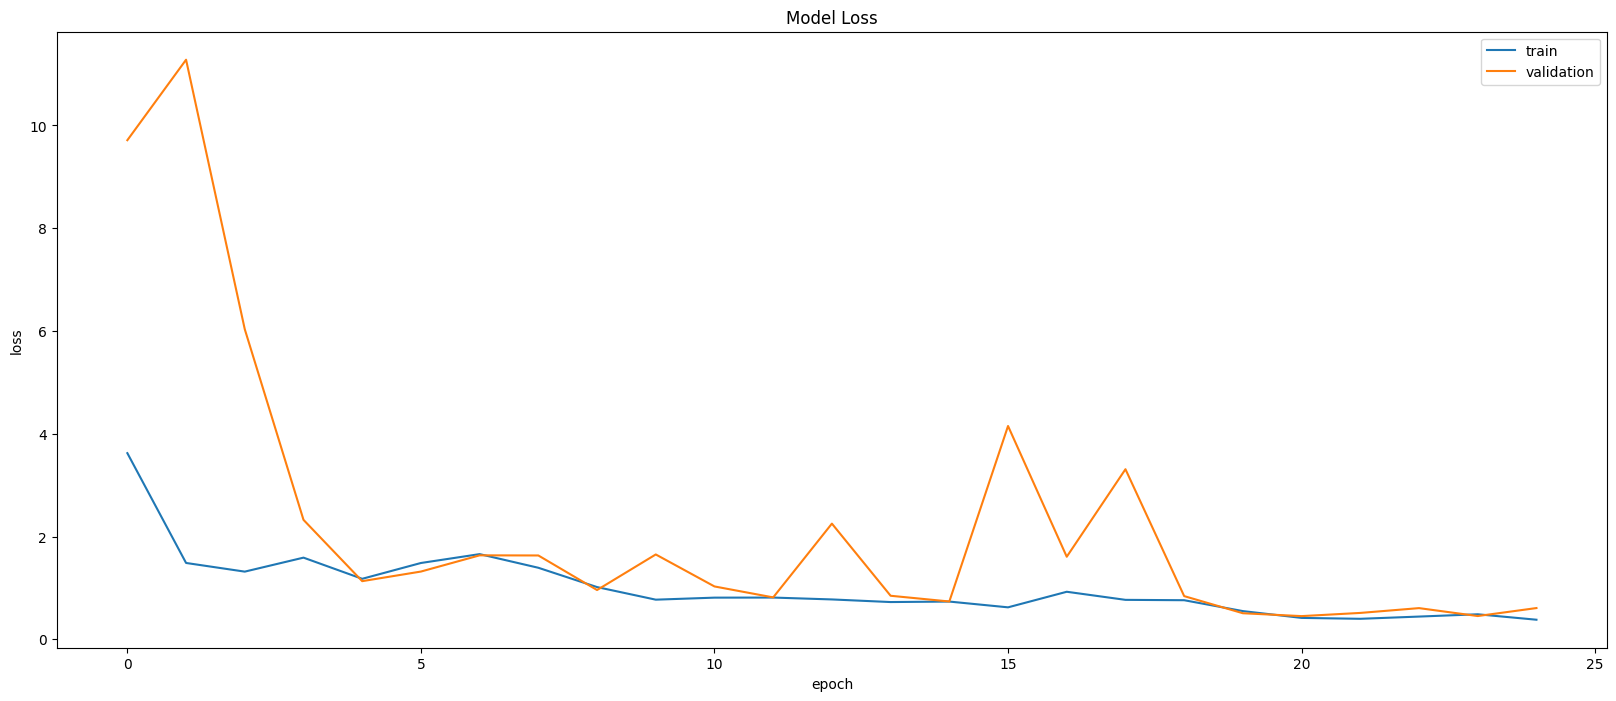

In [30]:
# Plot loss
plt.figure(figsize=(20, 8))
plt.plot(best_model_history.history['loss'])
plt.plot(best_model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
best_model.save('best_model_c.keras')